In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import sys
from contextlib import contextmanager
from multiprocessing.pool import ThreadPool
import sys
import time
import math, pywt
import argparse as ap
from skimage.transform import warp, AffineTransform
from operator import itemgetter
from pathlib import Path
import cupy as cp

# Matching without DL

# Feature Descriptors


# SIFT

In [2]:
def sift(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

In [134]:
def sift_n(image,nfeatures):
    sift = cv2.SIFT_create(nfeatures)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# NG_SIFT

In [194]:
def normalize_gradients(image):
    # Calculate gradients using Sobel operators
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate magnitude and angle of gradients
    magnitude = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)
    
    # Normalize gradients
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    angle = ((angle + np.pi) * 180 / np.pi / 360 * 255).astype(np.uint8)
    
    return magnitude, angle

def ng_sift(image):
    
    # Normalize gradients
    magnitude1, angle1 = normalize_gradients(image1)
    
    # Initialize NGSIFT detector
    ngsift = cv2.SIFT_create()
    
    # Find keypoints and descriptors
    keypoints1, descriptors1 = ngsift.detectAndCompute(magnitude1, None)
    return keypoints1,descriptors1

# ASIFT

In [5]:
MAX_SIZE = 1000

# Parameters for matching keypoints using FLANN algorithm
FLANN_INDEX_KDTREE = 1

FLANN_INDEX_LSH = 6

In [167]:
def init_feature(name):
    chunks = name.split('-')

    if chunks[0] == 'sift':
        detector = cv2.SIFT_create()
        norm = cv2.NORM_L2
    elif chunks[0] == 'surf':
        detector = cv2.xfeatures2d.SURF_create(800)     # SURF is a patented algorithm and may not work in some OpenCV builds
        norm = cv2.NORM_L2
    elif chunks[0] == 'orb':
        detector = cv2.ORB_create(400)
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'akaze':
        detector = cv2.AKAZE_create()
        norm = cv2.NORM_HAMMING
    elif chunks[0] == 'brisk':
        detector = cv2.BRISK_create()
        norm = cv2.NORM_HAMMING
    else:
        return None, None   # Return None if unknown detector name

    if 'flann' in chunks:
        if norm == cv2.NORM_L2:
            flann_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        else:
            flann_params = dict(algorithm=FLANN_INDEX_LSH,
                                table_number=6,  # 12
                                key_size=12,  # 20
                                multi_probe_level=1)  # 2

        matcher = cv2.FlannBasedMatcher(flann_params)
    else:
        matcher = cv2.BFMatcher(norm)

    return detector, matcher


def filter_matches(kp1, kp2, matches, ratio=0.75):
    mkp1, mkp2 = [], []

    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append(kp1[m.queryIdx])
            mkp2.append(kp2[m.trainIdx])

    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)

    return p1, p2, list(kp_pairs)


def draw_match(result_title, img1, img2, kp_pairs, status=None, H=None):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Create visualized result image
    vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)
    vis[:h1, :w1] = img1
    vis[:h2, w1:w1 + w2] = img2
    vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

    if H is not None:
        corners = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
        corners = np.int32(cv2.perspectiveTransform(corners.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0))
        cv2.polylines(vis, [corners], True, (255, 255, 255))

    if status is None:
        status = np.ones(len(kp_pairs), np.bool_)
    p1, p2 = [], []  # python 2 / python 3 change of zip unpacking

    for kpp in kp_pairs:
        p1.append(np.int32(kpp[0].pt))
        p2.append(np.int32(np.array(kpp[1].pt) + [w1, 0]))

    green = (0, 255, 0)
    red = (0, 0, 255)

    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            color = green
            cv2.circle(vis, (x1, y1), 2, color, -1)
            cv2.circle(vis, (x2, y2), 2, color, -1)
        else:
            color = red
            r = 2
            thickness = 3
            cv2.line(vis, (x1 - r, y1 - r), (x1 + r, y1 + r), color, thickness)
            cv2.line(vis, (x1 - r, y1 + r), (x1 + r, y1 - r), color, thickness)
            cv2.line(vis, (x2 - r, y2 - r), (x2 + r, y2 + r), color, thickness)
            cv2.line(vis, (x2 - r, y2 + r), (x2 + r, y2 - r), color, thickness)

    for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
        if inlier:
            cv2.line(vis, (x1, y1), (x2, y2), green)

    plt.imshow(vis)

#     return vis

In [163]:
def image_resize(src, ratio: float):
    dim = (int(src.shape[-1] * ratio), int(src.shape[0] * ratio))
    return cv2.resize(src, dim, interpolation=cv2.INTER_AREA)


def image_split(src):
    w = src.shape[1]
    half = int(w / 2)
    left_img = src[:, half:]
    right_img = src[:, :half]

    return left_img, right_img

In [166]:
def affine_skew(tilt, phi, img, mask=None):
    h, w = img.shape[:2]

    if mask is None:
        mask = np.zeros((h, w), np.uint8)
        mask[:] = 255

    A = np.float32([[1, 0, 0], [0, 1, 0]])

    # Rotate image
    if phi != 0.0:
        phi = np.deg2rad(phi)
        s, c = np.sin(phi), np.cos(phi)
        A = np.float32([[c, -s], [s, c]])
        corners = [[0, 0], [w, 0], [w, h], [0, h]]
        tcorners = np.int32(np.dot(corners, A.T))
        x, y, w, h = cv2.boundingRect(tcorners.reshape(1, -1, 2))
        A = np.hstack([A, [[-x], [-y]]])
        img = cv2.warpAffine(img, A, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    # Tilt image (resizing after rotation)
    if tilt != 1.0:
        s = 0.8 * np.sqrt(tilt * tilt - 1)
        img = cv2.GaussianBlur(img, (0, 0), sigmaX=s, sigmaY=0.01)
        img = cv2.resize(img, (0, 0), fx=1.0 / tilt, fy=1.0, interpolation=cv2.INTER_NEAREST)
        A[0] /= tilt

    if phi != 0.0 or tilt != 1.0:
        h, w = img.shape[:2]
        mask = cv2.warpAffine(mask, A, (w, h), flags=cv2.INTER_NEAREST)

    Ai = cv2.invertAffineTransform(A)

    return img, mask, Ai


def affine_detect(detector, img, pool=None):
    params = [(1.0, 0.0)]

    # Simulate all possible affine transformations
    for t in 2 ** (0.5 * np.arange(1, 6)):
        for phi in np.arange(0, 180, 72.0 / t):
            params.append((t, phi))

    def f(p):
        t, phi = p
        timg, tmask, Ai = affine_skew(t, phi, img)
        keypoints, descrs = detector.detectAndCompute(timg, tmask)

        for kp in keypoints:
            x, y = kp.pt
            kp.pt = tuple(np.dot(Ai, (x, y, 1)))

        if descrs is None:
            descrs = []

        return keypoints, descrs

    keypoints, descrs = [], []

    ires = pool.imap(f, params)

    for i, (k, d) in enumerate(ires):
#         print(f"Affine sampling: {i + 1} / {len(params)}\r", end='')
        keypoints.extend(k)
        descrs.extend(d)

    print()

    return keypoints, np.array(descrs)


def asift_main(image1: str, image2: str, detector_name: str = "sift-flann"):
    # Read images
    ori_img1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    ori_img2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)

    # Initialize feature detector and keypoint matcher
    detector, matcher = init_feature(detector_name)

    # Exit when reading empty image
    if ori_img1 is None or ori_img2 is None:
        print("Failed to load images")
        sys.exit(1)

    # Exit when encountering unknown detector parameter
    if detector is None:
        print(f"Unknown detector: {detector_name}")
        sys.exit(1)

    ratio_1 = 1
    ratio_2 = 1
    

    if ori_img1.shape[0] > MAX_SIZE or ori_img1.shape[1] > MAX_SIZE:
        ratio_1 = MAX_SIZE / ori_img1.shape[1]
#         print("Large input detected, image 1 will be resized")
        img1 = image_resize(ori_img1, ratio_1)
    else:
        img1 = ori_img1

    if ori_img2.shape[0] > MAX_SIZE or ori_img2.shape[1] > MAX_SIZE:
        ratio_2 = MAX_SIZE / ori_img2.shape[1]
#         print("Large input detected, image 2 will be resized")
        img2 = image_resize(ori_img2, ratio_2)
    else:
        img2 = ori_img2

#     print(f"Using {detector_name.upper()} detector...")

    # Profile time consumption of keypoints extraction
#     with Timer(f"Extracting {detector_name.upper()} keypoints..."):
    pool = ThreadPool(processes=cv2.getNumberOfCPUs())
    kp1, desc1 = affine_detect(detector, img1, pool=pool)
    kp2, desc2 = affine_detect(detector, img2, pool=pool)

#     print(f"img1 - {len(kp1)} features, img2 - {len(kp2)} features")

    # Profile time consumption of keypoints matching
#     with Timer('Matching...'):
    raw_matches = matcher.knnMatch(desc1, trainDescriptors=desc2, k=2)

    p1, p2, kp_pairs = filter_matches(kp1, kp2, raw_matches)

    if len(p1) >= 4:
        # TODO: The effect of resizing on homography matrix needs to be investigated.
        # TODO: Investigate function consistency when image aren't resized.
        for index in range(len(p1)):
            pt = p1[index]
            p1[index] = pt / ratio_1

        for index in range(len(p2)):
            pt = p2[index]
            p2[index] = pt / ratio_2

        for index in range(len(kp_pairs)):
            element = kp_pairs[index]
            kp1, kp2 = element

            new_kp1 = cv2.KeyPoint(kp1.pt[0] / ratio_1, kp1.pt[1] / ratio_1, kp1.size)
            new_kp2 = cv2.KeyPoint(kp2.pt[0] / ratio_2, kp2.pt[1] / ratio_2, kp2.size)

            kp_pairs[index] = (new_kp1, new_kp2)

        H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
#         print(f"{np.sum(status)} / {len(status)}  inliers/matched")
        # do not draw outliers (there will be a lot of them)
        kp_pairs = [kpp for kpp, flag in zip(kp_pairs, status) if flag]
    else:
        H, status = None, None
        print(f"{len(p1)} matches found, not enough for homography estimation")

    # kp_pairs: list[(cv2.KeyPoint, cv2.KeyPoint)]
#     print(len(kp_pairs))
#     print(kp_pairs)
    kp_pairs=kp_pairs[:1000]
    draw_match("ASIFT Match Result", ori_img1, ori_img2, kp_pairs, None, H)     # Visualize result
#     cv2.waitKey()

#     log_keypoints(kp_pairs, "sample/keypoints.txt")     # Save keypoint pairs for further inspection

#     print('Done')


# MOPS

In [150]:
def read_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("`{}` not cannot be loaded".format(image_path))
    return img

def draw_matches(matches, img_left, img_right, verbose=False):
    # Determine the max height
    height = max(img_left.shape[0], img_right.shape[0])
    # Width is the two images side-by-side
    width = img_left.shape[1] + img_right.shape[1]

    img_out = np.zeros((height, width, 3), dtype=np.uint8)
    # Place the images in the empty image 
    img_out[0:img_left.shape[0], 0:img_left.shape[1], :] = img_left
    img_out[0:img_right.shape[0], img_left.shape[1]:, :] = img_right

    # The right image coordinates are offset since the image is no longer at (0,0)
    ow = img_left.shape[1]
   
    #Draw a line between the matched pairs in green
    for p1,p2 in matches:
        p1o = (int(p1[1]), int(p1[0]))
        p2o = (int(p2[1] + ow), int(p2[0]))
        color = list(np.random.random(size=3) * 256)
        cv2.line(img_out, p1o, p2o, color, thickness=2)

    if verbose:
        print("Press enter to continue ... ")
        cv2.imshow("matches", img_out)
        cv2.waitKey(0)

    plt.imshow(img_out)

class Timer(object):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.secs = self.end - self.start
        self.mins = self.secs // 60
        self.msecs = self.secs * 1000  # millisecs
        if self.verbose:
            print('elapsed time: {:.2f} s ({:.4f} ms)'.format(self.secs, self.msecs))

In [10]:
def harris(img, sigma=1, threshold=0.01):
    height, width = img.shape
    shape = (height, width)
    # Calculate the dx,dy gradients of the image (np.gradient doesnt work)
    dx = cv2.Sobel(img, cv2.CV_64F,1,0,ksize=5)
    dy = cv2.Sobel(img, cv2.CV_64F,0,1,ksize=5)
    # Get angle for rotation
    _, ang = cv2.cartToPolar(dx, dy, angleInDegrees=True)
    # Square the derivatives (A,B,C of H) and apply apply gaussian filters to each
    sigma = (sigma, sigma)
    Ixx = cv2.GaussianBlur(dx * dx, sigma, 0)
    Ixy = cv2.GaussianBlur(dx * dy, sigma, 0)
    Iyy = cv2.GaussianBlur(dy * dy, sigma, 0)

    H = np.array([[Ixx, Ixy], [Ixy, Iyy]])
    # Find the determinate
    num = (H[0, 0] * H[1, 1]) - (H[0, 1] * H[1, 0])
    # Find the trace
    denom = H[0,0] + H[1,1]
    # Find the response using harmonic mean of the eigenvalues (Brown et. al. variation) 
    R = np.nan_to_num(num / denom)
    
    # Adaptive non-maximum suppression, keep the top 1% of values and remove non-maximum points in a 9x9 neighbourhood
    R_flat = R[:].flatten()
    # Get number of values in top threshold %
    N = int(len(R_flat) * threshold)
    # Get values in top threshold %
    top_k_percentile = np.partition(R_flat, -N)[-N:]
    # Find lowest value in top threshold %
    minimum = np.min(top_k_percentile)
    # Set all values less than this to 0
    R[R < minimum] = 0
    # Set non-maximum points in an SxS neighbourhood to 0
    s = 9
    for h in range(R.shape[0] - s):
        for w in range(R.shape[1] - s):
            maximum = np.max(R[h:h+s+1, w:w+s+1])
            for i in range(h, h+s+1):
                for j in range(w, w+s+1):
                    if R[i, j] != maximum:
                        R[i, j] = 0
                        
    # Return harris corners in [H, W, R] format
    features = list(np.where(R > 0))
    features.append(ang[np.where(R > 0)])
    corners = zip(*features)
    return list(corners)

def draw_corners(corners, img, name):
    for h, w, r in corners:
        cv2.circle(img, (w, h), 2, (0, 0, 255))

    cv2.imwrite(name + '.png', img)

In [148]:
def read_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("`{}` not cannot be loaded".format(image_path))
    return img

def ransac(pts1, pts2, img_l, img_r, max_iters=1000, epsilon=1):
    best_matches = []
    # Number of samples
    N = 4
    
    for i in range(max_iters):
        # Get 4 random samples from features
        idx = np.random.randint(0, len(pts1) - 1, N)
        src = pts1[idx]
        dst = pts2[idx]

        # Calculate the homography matrix H
        H = cv2.getPerspectiveTransform(src, dst)
        Hp = cv2.perspectiveTransform(pts1[None], H)[0]

        # Find the inliers by computing the SSD(p',Hp) and saving inliers (feature pairs) that are SSD(p',Hp) < epsilon
        inliers = []
        for i in range(len(pts1)):
            ssd = np.sum(np.square(pts2[i] - Hp[i]))
            if ssd < epsilon:
                inliers.append([pts1[i], pts2[i]])
        
        # Keep the largest set of inliers and the corresponding homography matrix
        if len(inliers) > len(best_matches):
            best_matches = inliers
    
    return best_matches

# Plotting tool for convenience
def plot(plots):
    fig = plt.figure()
    N = len(plots)
    x = math.ceil(math.sqrt(N))
    y = math.ceil(math.sqrt(N))
    for i in range(N):
        fig.add_subplot(x,y,i+1).imshow(plots[i])
    plt.show()

def mops(img, truth, win_size, h, w, r):
    H, W = img.shape
    offset = win_size // 2
    
    # Draw line for angle of gradient (for debugging)
    #length = 150
    #h2 =  int(h - length * math.cos(math.radians(r)))
    #w2 =  int(w - length * math.sin(math.radians(r)))
    #cv2.line(img, (w, h), (w2, h2), (0,255,0), 2)

    # Rotate image s.t. gradient angle of feature is origin
    M = cv2.getRotationMatrix2D((int(w),int(h) ), -1*r, 1)
    img_rot = cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_NEAREST)

    # Get 40x40 window around feature
    win = img_rot[h-offset:h+offset, w-offset:w+offset]

    # Size (s,s) of each sample region
    s = win_size // 8
    # Prefiltering (N,N) -> (N//s, N//s)
    i = 0
    rows = []
    while i < win_size:
        j = 0
        cols = []
        while j < win_size:
            # Sample (s,s) region from window
            sample = win[i:i+s, j:j+s]
            # Downsample (s,s) region to a single value
            sample = np.sum(sample) / (s*s)
            cols.append(sample)
            j += s
        rows.append(cols)
        i += s
    
    feature = np.array(rows)
    # Normalize
    feature = (feature - np.mean(feature)) / np.std(feature)
    # Haar wave transform
    coeffs = pywt.dwt2(feature, 'haar')
    feature = pywt.idwt2(coeffs, 'haar')
    #plot([img, img_rot, truth, win, feature])
    return feature

def get_matches(ft1, ft2, left_match, right_match, img_left, img_right, max_matches, win_size):
    potential_matches = []
    offset = win_size // 2

    # Feature descriptor with brute-force matching
    for h1, w1, r1 in ft1:
        
        # Copy image as to not modify it by reference
        img_left_tmp = np.copy(img_left)

        # Copy coordinates incase changed by border
        h1_tmp = h1
        w1_tmp = w1

        # Get 40x40 window around feature
        win_left = img_left[h1-offset:h1+offset, w1-offset:w1+offset]

        # Handle border points
        if win_left.shape != (win_size, win_size):
            diff_h, diff_w = np.subtract(win_left.shape, (win_size, win_size))
            p_h = abs(diff_h // 2)
            p_w = abs(diff_w // 2)
            img_left_tmp = cv2.copyMakeBorder(img_left_tmp, p_h, p_h, p_w, p_w, cv2.BORDER_REFLECT)
            h1 += p_h
            w1 += p_w
            win_left = img_left_tmp[h1-offset:h1+offset, w1-offset:w1+offset]
        
        # Run multiscale oriented patches descriptor
        feature_left = mops(img_left_tmp, win_left, win_size, h1, w1, r1)
        lowest_dist = math.inf
        potential_match = ()
        for h2, w2, r2 in ft2:

            # Copy image as to not modify it by reference
            img_right_tmp = np.copy(img_right)

            # Copy coordinates incase changed by border
            h2_tmp = h2
            w2_tmp = w2

            # Get 40x40 window around feature
            win_right = img_right[h2-offset:h2+offset, w2-offset:w2+offset]

            # Handle border points
            if win_right.shape != (win_size, win_size):
                diff_h, diff_w = np.subtract(win_right.shape, (win_size, win_size))
                p_h = abs(diff_h // 2)
                p_w = abs(diff_w // 2)
                img_right_tmp = cv2.copyMakeBorder(img_right_tmp, p_h, p_h, p_w, p_w, cv2.BORDER_REFLECT)
                h2 += p_h
                w2 += p_w
                win_right = img_right_tmp[h2-offset:h2+offset, w2-offset:w2+offset]

            # Run multiscale oriented patches descriptor
            feature_right = mops(img_right_tmp, win_right, win_size, h2, w2, r2)
            # Check distance between features
            curr_dist = np.linalg.norm(feature_left - feature_right)
            if curr_dist < lowest_dist:
                lowest_dist = curr_dist
                potential_match = ([h1_tmp, w1_tmp, r1], [h2_tmp, w2_tmp, r2], curr_dist)
        
        potential_matches.append(potential_match)
#     print("pot")
    # Sort matches from smallest distance up
    matches = sorted(potential_matches, key=itemgetter(2))
    for match in matches:
        # Ensure no duplicates
        if match[0][0:2] not in left_match and match[1][0:2] not in right_match:
            # Add to matches
            left_match.append(match[0][0:2])
            right_match.append(match[1][0:2])
            # Remove from potential matches
            ft1.remove(tuple(match[0]))
            ft2.remove(tuple(match[1]))
#     print("anu")
    # Recursively keep going until every point has a match
    while(len(left_match) < max_matches and len(right_match) < max_matches):
#         print('anotha one')
        get_matches(ft1, ft2, left_match, right_match, img_left, img_right, max_matches, win_size)
#     print("dev")
    return np.array(left_match, dtype=np.float32), np.array(right_match, dtype=np.float32)

def MOPS(image_path1,image_path2):
    # Load the image
    img_left_clr   = read_image(image_path1)
    img_right_clr = read_image(image_path2)

    # Convert to grayscale
    img_left = cv2.cvtColor(img_left_clr, cv2.COLOR_BGR2GRAY)
    img_right = cv2.cvtColor(img_right_clr, cv2.COLOR_RGB2GRAY)

    print("Getting the features from the Harris Detector")
    ftL = harris(img_left, sigma=3, threshold=0.01)
    draw_corners(ftL, img_left_clr, 'corners_left')
    ftR = harris(img_right, sigma=3, threshold=0.01)
    draw_corners(ftR, img_right_clr, 'corners_right')
    
    print("  -- Number of features (left): ", len(ftL))
    print("  -- Number of features (right): ", len(ftR))
    print("Finding the best matches between images")
    with Timer(verbose=True) as t:
        max_matches = min(len(ftL), len(ftR))
        ptsL,ptsR = get_matches(ftL, ftR, [], [], img_left, img_right, max_matches, win_size=50)
        
        print(" -- Number of matches = ", len(ptsL))
        assert len(ptsL) == len(ptsR)

    print("Performing RANSAC")
    matches = ransac(ptsL,ptsR, img_left, img_right, 1000, 100)
    print(" -- Number of pruned matches = ", len(matches))
    
    draw_matches(matches, img_left_clr, img_right_clr)

# Filtering keypoints by response and spatial distance

In [12]:
def filter_keypoints(keypoints, descriptors, response_threshold=0.015, min_distance=5):
    
    for kp in keypoints:
        if kp.response > response_threshold:
            filtered_keypoints.append(kp)
    filtered_keypoints_dist = []
    for kp in filtered_keypoints:
        # Check if the keypoint is sufficiently far from existing keypoints
        if all(cv2.norm(np.array(kp.pt) - np.array(kp_dist.pt)) > min_distance for kp_dist in filtered_keypoints_dist):
            filtered_keypoints_dist.append(kp)
    # Filter descriptors corresponding to filtered keypoints
    filtered_descriptors = np.array([descriptors[i] for i, kp in enumerate(keypoints) if kp in filtered_keypoints_dist])

    return filtered_keypoints_dist, filtered_descriptors

# Matching ALgorithms

# FLANN

In [51]:
def flann(descriptors1,descriptors2):   
    # Match descriptors using a FLANN-based matcher
    flann = cv2.FlannBasedMatcher()
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    return matches

# Gale-Shapley

In [135]:
def stable_matching_cpu(descriptors1, descriptors2, percent=0.5):
#     descriptors1=descriptors1[:nfeatures]
#     descriptors2=descriptors2[:nfeatures]
    
    descriptors1 = np.array(descriptors1)
    descriptors2 = np.array(descriptors2)

    distances = np.linalg.norm(descriptors1[:, np.newaxis] - descriptors2, axis=2)
    min_value = np.amin(distances)
    max_value = np.amax(distances)
    threshold = percent * max_value

    matches = np.empty((0, 2), dtype=np.int32)
    unmatched_descriptors1 = np.arange(len(descriptors1))
    unmatched_descriptors2 = np.arange(len(descriptors2))

    while unmatched_descriptors1.size > 0:
        descriptor1_index = unmatched_descriptors1[0]
        descriptor1_distances = distances[descriptor1_index]
        best_descriptor2_index = np.argmin(descriptor1_distances)
        best_distance = descriptor1_distances[best_descriptor2_index]

        if best_distance < threshold:
            descriptor2_index = best_descriptor2_index

            if descriptor2_index in unmatched_descriptors2:
                unmatched_descriptors2 = np.delete(unmatched_descriptors2, np.where(unmatched_descriptors2 == descriptor2_index))
                matches = np.vstack((matches, np.array([[descriptor1_index, descriptor2_index]], dtype=np.int32)))
            else:
                current_match_indices = np.where(matches[:, 1] == descriptor2_index)
                current_match_descriptor1_index = matches[current_match_indices][0][0]

                if distances[descriptor1_index][descriptor2_index] < distances[current_match_descriptor1_index][descriptor2_index]:
                    unmatched_descriptors1 = np.append(unmatched_descriptors1, current_match_descriptor1_index)
                    unmatched_descriptors2 = np.append(unmatched_descriptors2, descriptor2_index)
                    matches = np.delete(matches, current_match_indices, axis=0)
                    matches = np.vstack((matches, np.array([[descriptor1_index, descriptor2_index]], dtype=np.int32)))
                else:
                    unmatched_descriptors1 = np.delete(unmatched_descriptors1, 0)
        else:
            unmatched_descriptors1 = np.delete(unmatched_descriptors1, 0)

    return matches


# PSR-EM method

In [144]:
def find_matches_em(descriptors1, descriptors2, num_components):

#     all_descriptors = np.vstack((descriptors1, descriptors2))
    max_iterations = 100
    tol = 1e-4
    # Fit Gaussian Mixture Model to the concatenated descriptors
    gmm = GaussianMixture(n_components=num_components, max_iter=max_iterations, tol=tol)
    gmm.fit(descriptors1)
    means1= gmm.means_
    gmm = GaussianMixture(n_components=num_components, max_iter=max_iterations, tol=tol)
    gmm.fit(descriptors2)
    means2 = gmm.means_
    # Fit Gaussian Mixture Models to the descriptors of both images
    gmm_image1 = GaussianMixture(n_components=num_components, covariance_type='full', means_init=means1)
    gmm_image1.fit(descriptors1)
    gmm_image2 = GaussianMixture(n_components=num_components, covariance_type='full', means_init=means2)
    gmm_image2.fit(descriptors2)

    # Calculate likelihoods of descriptors in the second image under the GMM of the first image
    likelihoods_image2_under_image1 = gmm_image1.score_samples(descriptors2)

    # Calculate likelihoods of descriptors in the first image under the GMM of the second image
    likelihoods_image1_under_image2 = gmm_image2.score_samples(descriptors1)

    # Find matches based on closest likelihoods
    matches = []
    for i in range(len(descriptors1)):
        closest_indices_image2 = np.argsort(likelihoods_image2_under_image1)[::-1]
        closest_indices_image1 = np.argsort(likelihoods_image1_under_image2)[::-1]

        # Find the closest unmatched descriptor in the second image
        for idx in closest_indices_image2:
            if idx not in [match[1] for match in matches]:
                closest_index_image2 = idx
                break

        # Find the closest unmatched descriptor in the first image
        for idx in closest_indices_image1:
            if idx not in [match[0] for match in matches]:
                closest_index_image1 = idx
                break

        # Add the match to the list
        matches.append([closest_index_image1, closest_index_image2])

    return np.array(matches)


# converting to dmatch

In [18]:
def convert_to_dmatches(matches):
    dmatches = []
    for match in matches:
        # Extract indices of keypoints from the match
        query_idx = match[0]
        train_idx = match[1]
        # Create a DMatch object
        dmatch =a cv2.DMatch(_queryIdx=query_idx, _trainIdx=train_idx, _distance=0)  # Set _distance to 0
        dmatches.append(dmatch)
    return dmatches

# plotting matched image

In [112]:
def show_matched_image_with_lines(image1, image2, keypoints1, keypoints2, matches):
    # Draw lines between matched keypoints
    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Draw lines connecting matched keypoints
#     for match in matches:
#         # Get the keypoints for each match
#         query_idx = match.queryIdx
#         train_idx = match.trainIdx
#         # Get the coordinates of each keypoint
#         (x1, y1) = keypoints1[query_idx].pt
#         (x2, y2) = keypoints2[train_idx].pt
#         # Draw a line between the keypoints
#         cv2.line(matched_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
    
    # Display the matched image with lines
    plt.imshow(matched_image)
    plt.show()

# Lowe's Ratio filtering for matches

In [75]:
def lowe(matches):
    # Perform Lowe's ratio test to filter out ambiguous matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return good_matches

In [191]:
images=["/kaggle/input/cv-data2/24378750_4403814739.jpg","/kaggle/input/cv-data2/78242267_4404579754.jpg"]

In [192]:
image1 = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(images[1], cv2.IMREAD_GRAYSCALE)

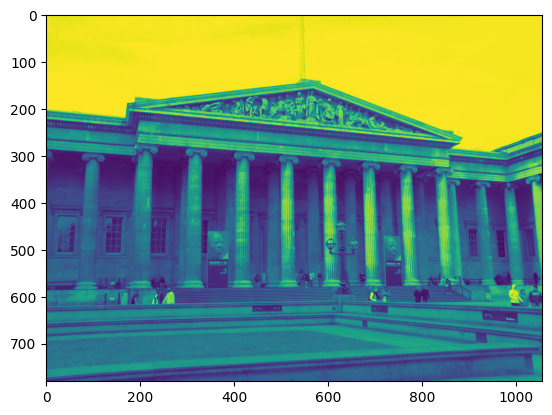

In [73]:
plt.imshow(image1)

# SIFT with FLANN

Lowe's ratio : 0.36981258366800535


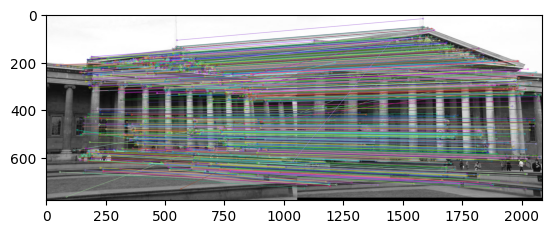

In [89]:
keypoints1,descriptors1=sift(image1)
keypoints2,descriptors2=sift(image2)
matches=flann(descriptors1,descriptors2)
good_matches=lowe(matches)
print("Lowe's ratio :",len(good_matches)/len(matches))
matches_sift = [[match] for match in good_matches]
matched_image = cv2.drawMatchesKnn(image1,keypoints1, image2, keypoints2,matches_sift, None, flags=2)
plt.imshow(matched_image)
plt.show()

# SIFT with gale-shapley

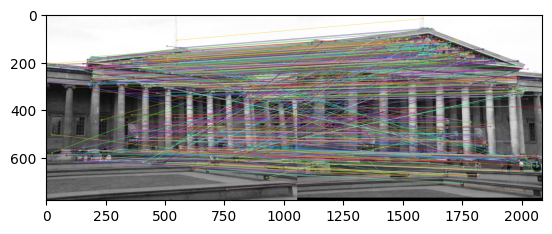

In [136]:
keypoints1,descriptors1=sift_n(image1,nfeatures=1500)
keypoints2,descriptors2=sift_n(image2,nfeatures=1500)
# print(len(keypoints1))
matches=stable_matching_cpu(descriptors1, descriptors2, percent=0.5)
matches=convert_to_dmatches(matches)
show_matched_image_with_lines(image1, image2, keypoints1, keypoints2, matches)

# SIFT with EM

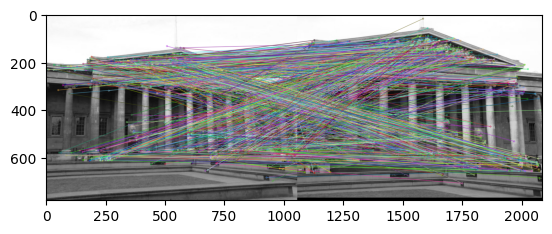

In [145]:
keypoints1,descriptors1=sift_n(image1,nfeatures=1000)
keypoints2,descriptors2=sift_n(image2,nfeatures=1000)
# print(len(keypoints1))
num_components=10
matches=find_matches_em(descriptors1,descriptors2,num_components)
matches=convert_to_dmatches(matches)
show_matched_image_with_lines(image1, image2, keypoints1, keypoints2, matches)

# MOPS

Getting the features from the Harris Detector


/tmp/ipykernel_34/97295701.py:21: RuntimeWarning: invalid value encountered in divide
  R = np.nan_to_num(num / denom)


  -- Number of features (left):  311
  -- Number of features (right):  341
Finding the best matches between images
 -- Number of matches =  311
elapsed time: 443.14 s (443142.5920 ms)
Performing RANSAC
 -- Number of pruned matches =  13


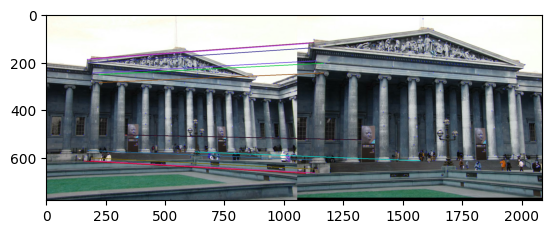

In [151]:
MOPS(images[0],images[1])

# ASIFT

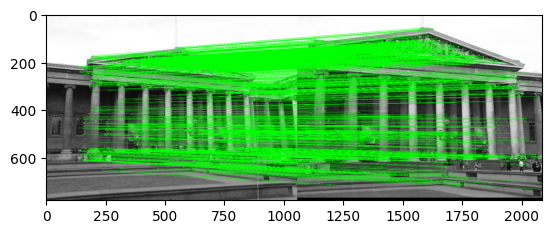

In [168]:
asift_main(images[0], images[1], detector_name= "sift-flann")

Lowe's ratio : 1.0


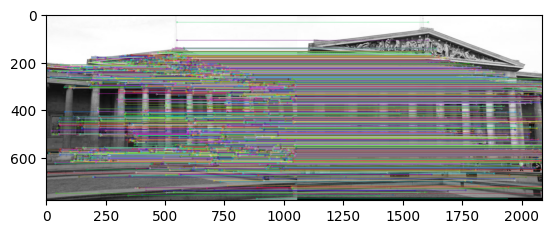

In [206]:
keypoints1, descriptors1 = ng_sift(image1)
keypoints2, descriptors2 = ng_sift(image2)
matches=flann(descriptors1,descriptors2)
good_matches=lowe(matches)
print("Lowe's ratio :",len(good_matches)/len(matches))
matches_sift = [[match] for match in good_matches]
matched_image = cv2.drawMatchesKnn(image1,keypoints1, image2, keypoints2,matches_sift, None, flags=2)
plt.imshow(matched_image)
plt.show()

# DL Matching

In [169]:
if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

/kaggle/working/LightGlue


In [170]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 59.1MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth
100%|██████████| 45.3M/45.3M [00:00<00:00, 195MB/s] 


2048


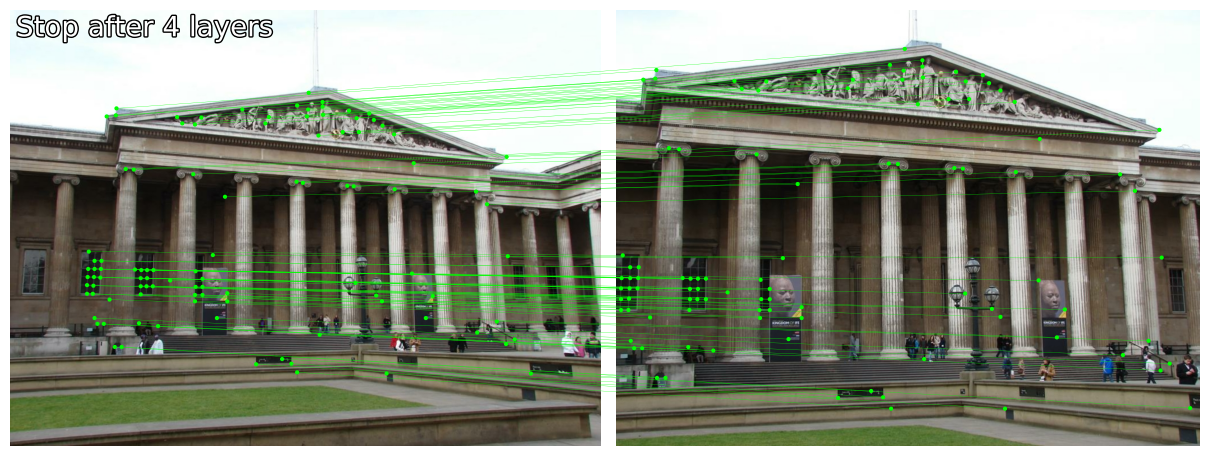

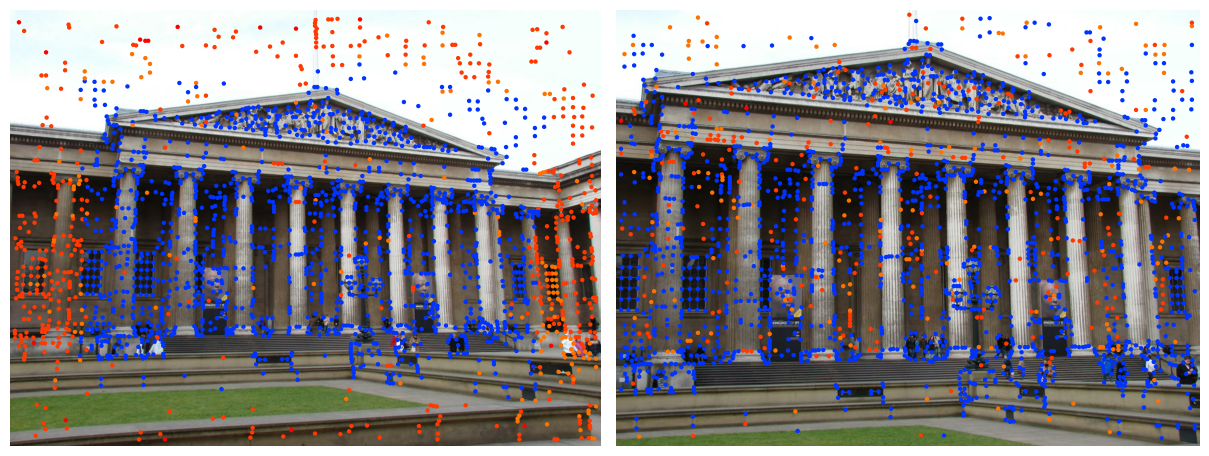

In [176]:
image0 = load_image("/kaggle/input/cv-data2/24378750_4403814739.jpg")
image1 = load_image("/kaggle/input/cv-data2/78242267_4404579754.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

m_kpts0 = m_kpts0[0:100]
print(len(kpts0))
m_kpts1 = m_kpts1[0:100]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

# Image_stitching

In [229]:
class Image_Stitching():
    def __init__(self) :
        self.ratio=0.85
        self.min_match=10
        self.sift=cv2.SIFT_create()
        self.smoothing_window_size=800

    def registration(self,img1,img2):
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        return H

    def create_mask(self,img1,img2,version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version== 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self,img1,img2):
        H = self.registration(img1,img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1,img2,version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result

    

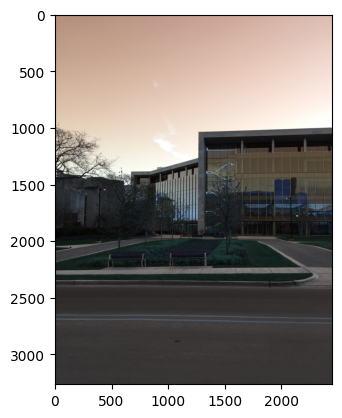

In [221]:
plt.imshow(img1)

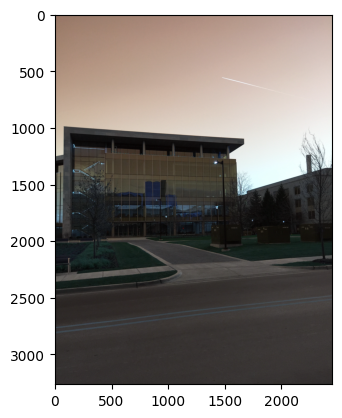

In [222]:
plt.imshow(img2)

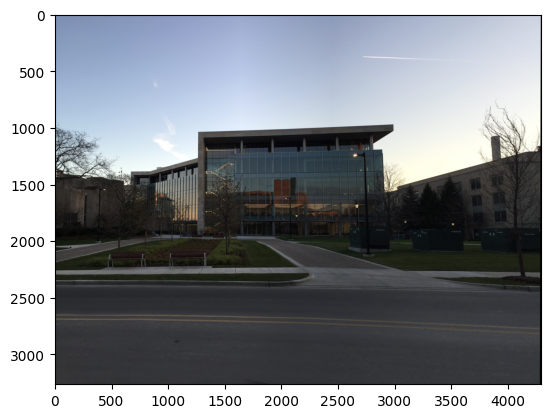

In [230]:
img1 = cv2.imread(r"/kaggle/input/cv-images/sample/q11.jpg")
img2 = cv2.imread(r"/kaggle/input/cv-images/sample/q22.jpg")
final=Image_Stitching().blending(img1,img2)
final_8u = cv2.convertScaleAbs(final)
final_rgb = cv2.cvtColor(final_8u, cv2.COLOR_BGR2RGB)
plt.imshow(final_rgb)